In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import warnings
import os
import csv
cwd = os.getcwd()
warnings.filterwarnings('ignore')
from tqdm import tqdm
from datetime import datetime
from zoneinfo import ZoneInfo
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

In [2]:
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from torch.optim import Adam,SGD,AdamW
import matplotlib.pyplot as plt

In [3]:
def get_timestamp():
    try:
        now = datetime.now(ZoneInfo("Asia/Kolkata"))
    except:
        print("Couldn't get Zone Info...")
        now = datetime.now()
    time_str = now.strftime("%d_%m_%H_%M")
    return time_str

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Dataset Initialization

In [5]:
train_transform = transforms.Compose([
    transforms.ToImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(size=32,padding=4),
    transforms.ToDtype(torch.float32,scale=True),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),std=(0.247, 0.243, 0.261))
])

test_transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32,scale=True),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),std=(0.247, 0.243, 0.261))
])

In [6]:
from torch.utils.data import default_collate

cutmix = transforms.CutMix(num_classes=10)
mixup = transforms.MixUp(num_classes=10)
cutmix_or_mixup = transforms.RandomChoice([cutmix, mixup])

def collate_fn(batch):
    return cutmix_or_mixup(*default_collate(batch))

In [7]:
# Train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root=os.path.join(cwd,"./data"),
    train=True,
    download=True,
    transform=train_transform # not using any augmentation for baseline
)

# Test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root=os.path.join(cwd,"./data"),
    train=False,
    download=True,
    transform=test_transform
)

100%|██████████| 170M/170M [00:02<00:00, 57.5MB/s]


In [8]:
from torch.utils.data import Subset

# Quick test with just 500 samples
# train_subset = Subset(train_dataset, range(1000))
train_subset = train_dataset
# test_subset = Subset(test_dataset, range(10000))
test_subset = test_dataset

In [9]:
train_loader = DataLoader(train_subset, batch_size=512, shuffle=True, num_workers = 8,collate_fn=collate_fn)
test_loader = DataLoader(test_subset, batch_size=512, shuffle=False, num_workers = 6)

### Model Class

In [10]:
class FeedForward(nn.Module):
    def __init__(self, feature_dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(feature_dim),
            nn.Linear(feature_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, feature_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, feature_dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(feature_dim)

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(feature_dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, feature_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class ShiftedPatchTokenization(nn.Module):
    def __init__(self, *, feature_dim, patch_size, channels = 3):
        super().__init__()
        patch_dim = patch_size * patch_size * 5 * channels

        self.to_patch_tokens = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, feature_dim)
        )

    def forward(self, x):
        shifts = ((1, -1, 0, 0), (-1, 1, 0, 0), (0, 0, 1, -1), (0, 0, -1, 1))
        shifted_x = list(map(lambda shift: F.pad(x, shift), shifts))
        x_with_shifts = torch.cat((x, *shifted_x), dim = 1)
        return self.to_patch_tokens(x_with_shifts)

class Transformer(nn.Module):
    def __init__(self, feature_dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(feature_dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(feature_dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(feature_dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, feature_dim, depth, heads, mlp_dim, channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = (image_size,image_size)
        patch_height, patch_width = (patch_size,patch_size)

        assert (image_height % patch_height == 0) and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        # patch_dim = channels * patch_height * patch_width
        # self.to_patch_embedding = nn.Sequential(
        #     Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
        #     nn.LayerNorm(patch_dim),
        #     nn.Linear(patch_dim, feature_dim),
        #     nn.LayerNorm(feature_dim),
        # )

        self.to_patch_embedding = ShiftedPatchTokenization(
            feature_dim=feature_dim,
            patch_size=patch_size,
            channels=channels
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, feature_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, feature_dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(feature_dim, depth, heads, dim_head, mlp_dim, dropout)

        self.mlp_head = nn.Linear(feature_dim, num_classes)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x[:, 0] # get the CLS token

        return self.mlp_head(x)

In [11]:
# model = ViT(
#     image_size=32,
#     num_classes=10,
#     patch_size=4,
#     feature_dim=256,
#     mlp_dim=512,
#     depth=6,
#     heads=4,
#     dropout=0.3,
#     emb_dropout=0.3,
#     )

In [12]:
# print(model)

In [13]:
# from torchinfo import summary
# summary(model,input_size=(64,3,32,32))

### Training Loop

In [14]:
class SimpleLogger:
    def __init__(self) -> None:
        self.epoch = []
        self.train_loss = []
        self.train_acc = []
        self.eval_loss = []
        self.eval_acc = []
        
    def log(self, metrics):
        self.epoch.append(metrics['epoch'])
        self.train_loss.append(metrics['train_loss'])
        self.train_acc.append(metrics['train_acc'])
        self.eval_loss.append(metrics['eval_loss'])
        self.eval_acc.append(metrics['eval_acc'])

    def plot_metrics(self, save_path=None,display=False):
        if not self.epoch:
            print("No metrics to plot. Train the model first.")
            return
        
        epochs = self.epoch
        train_losses = self.train_loss
        eval_losses = self.eval_loss
        train_accs = self.train_acc
        eval_accs = self.eval_acc
        
        plt.close()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot loss curves
        ax1.plot(epochs, train_losses, label='Train Loss', marker='o', linewidth=2)
        ax1.plot(epochs, eval_losses, label='Eval Loss', marker='s', linewidth=2)
        ax1.set_xlabel('Epochs', fontsize=12)
        ax1.set_ylabel('Loss', fontsize=12)
        ax1.set_title('Training and Evaluation Loss', fontsize=14, fontweight='bold')
        ax1.legend(loc='best')
        ax1.grid(True, alpha=0.3)
        
        # Plot accuracy curves
        ax2.plot(epochs, train_accs, label='Train Accuracy', marker='o', linewidth=2)
        ax2.plot(epochs, eval_accs, label='Eval Accuracy', marker='s', linewidth=2)
        ax2.set_xlabel('Epochs', fontsize=12)
        ax2.set_ylabel('Accuracy', fontsize=12)
        ax2.set_title('Training and Evaluation Accuracy', fontsize=14, fontweight='bold')
        ax2.legend(loc='best')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path is None and display==False:
            raise AttributeError('Must provide either save path or option to display.')
        else:
            if save_path:
                plt.savefig(save_path+".png", dpi=300, bbox_inches='tight')
                print(f"Plot saved to {save_path}")
            if display:
                plt.show()
    
    def store_log_as_csv(self, save_path=None):
        if save_path is None:
            raise ValueError("Save path cannot be None")
        
        save_path += '.csv'
        
        rows = []
        rows.append(["epoch", "train_loss", "train_acc", "eval_loss", "eval_acc"])
        
        for i in range(len(self.epoch)):
            rows.append([
                self.epoch[i],
                self.train_loss[i],
                self.train_acc[i],
                self.eval_loss[i],
                self.eval_acc[i]
            ])
        
        with open(save_path, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerows(rows)

In [15]:
class Trainer:
    def __init__(
        self,
        model,
        train_loader,
        test_loader,
        optimizer,
        loss_fn,
        scheduler=None,
        logger=None,
        ckpt_path="checkpoint.pt",
        device=device,
    ):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.scheduler = scheduler
        self.logger:SimpleLogger = logger
        self.ckpt_path = ckpt_path
        self.device = device
        self.model.to(self.device)
        self.best_acc = 0.0
        self.start_epoch = 0
        self._load_checkpoint()

    def _save_checkpoint(self, epoch, acc):
        state = {
            "epoch": epoch,
            "model_state": self.model.state_dict(),
            "optimizer_state": self.optimizer.state_dict(),
            "scheduler_state": self.scheduler.state_dict() if self.scheduler else None,
            "best_acc": acc,
        }
        torch.save(state, self.ckpt_path + '.pt')

    def _load_checkpoint(self):
        if os.path.isfile(self.ckpt_path + '.pt'):
            state = torch.load(self.ckpt_path + '.pt', map_location=self.device)
            self.model.load_state_dict(state["model_state"])
            self.optimizer.load_state_dict(state["optimizer_state"])
            if self.scheduler and state.get("scheduler_state"):
                self.scheduler.load_state_dict(state["scheduler_state"])
            self.best_acc = state.get("best_acc", 0.0)
            self.start_epoch = state.get("epoch", 0)

    def train(self, num_epochs):
        for epoch in range(self.start_epoch, num_epochs):
            print(f'Epoch {epoch}/{num_epochs}')
            train_loss, train_acc = self._train_one_epoch(epoch)
            eval_loss, eval_acc = self._evaluate(epoch)
            if self.logger:
                self.logger.log({
                    "epoch": epoch,
                    "train_loss": train_loss,
                    "train_acc": train_acc,
                    "eval_loss": eval_loss,
                    "eval_acc": eval_acc
                })
            if eval_acc > self.best_acc:
                self.best_acc = eval_acc
                print("Saving model...")
                self._save_checkpoint(epoch, eval_acc)
            if self.scheduler:
                self.scheduler.step()
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f} | Best Eval Acc: {self.best_acc:.2f}")
        
        self.logger.plot_metrics(save_path = self.ckpt_path)
        self.logger.store_log_as_csv(self.ckpt_path)
        return self.best_acc

    def _train_one_epoch(self, epoch):
        self.model.train()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        pbar = tqdm(self.train_loader, total=len(self.train_loader),desc="Training: ")
        for batch in pbar:
            x, y = batch[0].to(self.device), batch[1].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(x)

            if torch.is_floating_point(y) and y.dim() == 2:
                # y are soft labels
                log_probs = F.log_softmax(outputs, dim=1)
                # negative log-likelihood for soft labels
                loss = -(y * log_probs).sum(dim=1).mean()
            else:
                # assume standard class indices
                loss = self.loss_fn(outputs, y)
            
            loss = self.loss_fn(outputs, y)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item() * x.size(0)

            # need to calculate accuracy differently for soft labels
            labels = batch[1]
            if torch.is_floating_point(labels) and labels.dim() == 2:
                # compute accuracy by comparing argmax of soft labels
                target_indices = labels.argmax(dim=1).to(self.device)
                total_correct += (outputs.argmax(1) == target_indices).sum().item()
            else:
                total_correct += (outputs.argmax(1) == y).sum().item()
            total_samples += x.size(0)

        avg_loss = total_loss / total_samples
        avg_acc = total_correct / total_samples
        return avg_loss, avg_acc

    def _evaluate(self, epoch):
        self.model.eval()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        with torch.no_grad():
            pbar = tqdm(self.test_loader, total=len(self.test_loader),desc="Evaluating: ")
            for batch in pbar:
                x, y = batch[0].to(self.device), batch[1].to(self.device)
                outputs = self.model(x)
                loss = self.loss_fn(outputs, y)
                total_loss += loss.item() * x.size(0)
                total_correct += (outputs.argmax(1) == y).sum().item()
                total_samples += x.size(0)
        avg_loss = total_loss / total_samples
        avg_acc = total_correct / total_samples
        return avg_loss, avg_acc

Saving to checkpoint_04_10_19_23_SPT
Epoch 0/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Saving model...
Train Loss: 2.2766 | Train Acc: 0.15 | Best Eval Acc: 0.21
Epoch 1/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


Saving model...
Train Loss: 2.1840 | Train Acc: 0.19 | Best Eval Acc: 0.25
Epoch 2/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]


Saving model...
Train Loss: 2.1099 | Train Acc: 0.23 | Best Eval Acc: 0.34
Epoch 3/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Saving model...
Train Loss: 2.0301 | Train Acc: 0.29 | Best Eval Acc: 0.39
Epoch 4/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Saving model...
Train Loss: 1.9751 | Train Acc: 0.32 | Best Eval Acc: 0.44
Epoch 5/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Saving model...
Train Loss: 1.9306 | Train Acc: 0.34 | Best Eval Acc: 0.47
Epoch 6/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Saving model...
Train Loss: 1.8923 | Train Acc: 0.37 | Best Eval Acc: 0.51
Epoch 7/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 1.9044 | Train Acc: 0.37 | Best Eval Acc: 0.51
Epoch 8/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


Saving model...
Train Loss: 1.8686 | Train Acc: 0.39 | Best Eval Acc: 0.53
Epoch 9/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Saving model...
Train Loss: 1.8696 | Train Acc: 0.38 | Best Eval Acc: 0.54
Epoch 10/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Saving model...
Train Loss: 1.8151 | Train Acc: 0.41 | Best Eval Acc: 0.56
Epoch 11/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]


Train Loss: 1.7830 | Train Acc: 0.43 | Best Eval Acc: 0.56
Epoch 12/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Saving model...
Train Loss: 1.7799 | Train Acc: 0.44 | Best Eval Acc: 0.57
Epoch 13/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]


Train Loss: 1.8008 | Train Acc: 0.42 | Best Eval Acc: 0.57
Epoch 14/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Saving model...
Train Loss: 1.7267 | Train Acc: 0.45 | Best Eval Acc: 0.58
Epoch 15/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.7517 | Train Acc: 0.45 | Best Eval Acc: 0.58
Epoch 16/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


Saving model...
Train Loss: 1.7697 | Train Acc: 0.44 | Best Eval Acc: 0.60
Epoch 17/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


Train Loss: 1.7436 | Train Acc: 0.45 | Best Eval Acc: 0.60
Epoch 18/200


Evaluating: 100%|██████████| 20/20 [00:09<00:00,  2.22it/s]


Saving model...
Train Loss: 1.7247 | Train Acc: 0.46 | Best Eval Acc: 0.61
Epoch 19/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Saving model...
Train Loss: 1.7193 | Train Acc: 0.47 | Best Eval Acc: 0.62
Epoch 20/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.7107 | Train Acc: 0.47 | Best Eval Acc: 0.62
Epoch 21/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


Saving model...
Train Loss: 1.7257 | Train Acc: 0.47 | Best Eval Acc: 0.62
Epoch 22/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.6903 | Train Acc: 0.49 | Best Eval Acc: 0.62
Epoch 23/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]


Saving model...
Train Loss: 1.6794 | Train Acc: 0.50 | Best Eval Acc: 0.65
Epoch 24/200


Evaluating: 100%|██████████| 20/20 [00:09<00:00,  2.18it/s]


Train Loss: 1.6350 | Train Acc: 0.51 | Best Eval Acc: 0.65
Epoch 25/200


Evaluating: 100%|██████████| 20/20 [00:09<00:00,  2.16it/s]


Train Loss: 1.6302 | Train Acc: 0.52 | Best Eval Acc: 0.65
Epoch 26/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]


Train Loss: 1.6564 | Train Acc: 0.51 | Best Eval Acc: 0.65
Epoch 27/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Saving model...
Train Loss: 1.6739 | Train Acc: 0.50 | Best Eval Acc: 0.65
Epoch 28/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.6718 | Train Acc: 0.49 | Best Eval Acc: 0.65
Epoch 29/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.6640 | Train Acc: 0.50 | Best Eval Acc: 0.65
Epoch 30/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Saving model...
Train Loss: 1.6297 | Train Acc: 0.51 | Best Eval Acc: 0.66
Epoch 31/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Saving model...
Train Loss: 1.6421 | Train Acc: 0.51 | Best Eval Acc: 0.66
Epoch 32/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


Saving model...
Train Loss: 1.6102 | Train Acc: 0.52 | Best Eval Acc: 0.69
Epoch 33/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.6146 | Train Acc: 0.53 | Best Eval Acc: 0.69
Epoch 34/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


Train Loss: 1.5859 | Train Acc: 0.54 | Best Eval Acc: 0.69
Epoch 35/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]


Saving model...
Train Loss: 1.5758 | Train Acc: 0.54 | Best Eval Acc: 0.69
Epoch 36/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.5855 | Train Acc: 0.54 | Best Eval Acc: 0.69
Epoch 37/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Saving model...
Train Loss: 1.5490 | Train Acc: 0.56 | Best Eval Acc: 0.71
Epoch 38/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


Train Loss: 1.5505 | Train Acc: 0.56 | Best Eval Acc: 0.71
Epoch 39/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Saving model...
Train Loss: 1.5342 | Train Acc: 0.56 | Best Eval Acc: 0.72
Epoch 40/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Saving model...
Train Loss: 1.5296 | Train Acc: 0.57 | Best Eval Acc: 0.72
Epoch 41/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Train Loss: 1.5867 | Train Acc: 0.55 | Best Eval Acc: 0.72
Epoch 42/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Saving model...
Train Loss: 1.5148 | Train Acc: 0.58 | Best Eval Acc: 0.73
Epoch 43/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.4827 | Train Acc: 0.59 | Best Eval Acc: 0.73
Epoch 44/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]


Train Loss: 1.4561 | Train Acc: 0.60 | Best Eval Acc: 0.73
Epoch 45/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Saving model...
Train Loss: 1.4768 | Train Acc: 0.59 | Best Eval Acc: 0.74
Epoch 46/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.5327 | Train Acc: 0.58 | Best Eval Acc: 0.74
Epoch 47/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.5655 | Train Acc: 0.56 | Best Eval Acc: 0.74
Epoch 48/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.5205 | Train Acc: 0.57 | Best Eval Acc: 0.74
Epoch 49/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.4825 | Train Acc: 0.60 | Best Eval Acc: 0.74
Epoch 50/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


Train Loss: 1.5207 | Train Acc: 0.58 | Best Eval Acc: 0.74
Epoch 51/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Saving model...
Train Loss: 1.4616 | Train Acc: 0.61 | Best Eval Acc: 0.79
Epoch 52/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.3979 | Train Acc: 0.63 | Best Eval Acc: 0.79
Epoch 53/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.4293 | Train Acc: 0.62 | Best Eval Acc: 0.79
Epoch 54/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


Train Loss: 1.4540 | Train Acc: 0.61 | Best Eval Acc: 0.79
Epoch 55/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.4257 | Train Acc: 0.62 | Best Eval Acc: 0.79
Epoch 56/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Saving model...
Train Loss: 1.4293 | Train Acc: 0.63 | Best Eval Acc: 0.79
Epoch 57/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


Train Loss: 1.4182 | Train Acc: 0.62 | Best Eval Acc: 0.79
Epoch 58/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


Train Loss: 1.4772 | Train Acc: 0.61 | Best Eval Acc: 0.79
Epoch 59/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.4061 | Train Acc: 0.63 | Best Eval Acc: 0.79
Epoch 60/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


Train Loss: 1.3790 | Train Acc: 0.65 | Best Eval Acc: 0.79
Epoch 61/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Train Loss: 1.3667 | Train Acc: 0.66 | Best Eval Acc: 0.79
Epoch 62/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Train Loss: 1.4218 | Train Acc: 0.63 | Best Eval Acc: 0.79
Epoch 63/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Saving model...
Train Loss: 1.3826 | Train Acc: 0.64 | Best Eval Acc: 0.79
Epoch 64/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


Train Loss: 1.4006 | Train Acc: 0.65 | Best Eval Acc: 0.79
Epoch 65/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Saving model...
Train Loss: 1.3554 | Train Acc: 0.66 | Best Eval Acc: 0.81
Epoch 66/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]


Train Loss: 1.4038 | Train Acc: 0.64 | Best Eval Acc: 0.81
Epoch 67/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.3505 | Train Acc: 0.66 | Best Eval Acc: 0.81
Epoch 68/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


Saving model...
Train Loss: 1.3684 | Train Acc: 0.66 | Best Eval Acc: 0.81
Epoch 69/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Saving model...
Train Loss: 1.3218 | Train Acc: 0.69 | Best Eval Acc: 0.81
Epoch 70/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Saving model...
Train Loss: 1.3938 | Train Acc: 0.65 | Best Eval Acc: 0.82
Epoch 71/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Train Loss: 1.3345 | Train Acc: 0.66 | Best Eval Acc: 0.82
Epoch 72/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.3910 | Train Acc: 0.66 | Best Eval Acc: 0.82
Epoch 73/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 1.3419 | Train Acc: 0.67 | Best Eval Acc: 0.82
Epoch 74/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Saving model...
Train Loss: 1.3056 | Train Acc: 0.68 | Best Eval Acc: 0.82
Epoch 75/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Saving model...
Train Loss: 1.2964 | Train Acc: 0.70 | Best Eval Acc: 0.83
Epoch 76/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 1.3321 | Train Acc: 0.67 | Best Eval Acc: 0.83
Epoch 77/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


Train Loss: 1.3791 | Train Acc: 0.66 | Best Eval Acc: 0.83
Epoch 78/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Train Loss: 1.3188 | Train Acc: 0.69 | Best Eval Acc: 0.83
Epoch 79/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.2432 | Train Acc: 0.72 | Best Eval Acc: 0.83
Epoch 80/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Saving model...
Train Loss: 1.2981 | Train Acc: 0.68 | Best Eval Acc: 0.84
Epoch 81/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.3406 | Train Acc: 0.67 | Best Eval Acc: 0.84
Epoch 82/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.2717 | Train Acc: 0.71 | Best Eval Acc: 0.84
Epoch 83/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.2502 | Train Acc: 0.71 | Best Eval Acc: 0.84
Epoch 84/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 1.3170 | Train Acc: 0.70 | Best Eval Acc: 0.84
Epoch 85/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 1.2882 | Train Acc: 0.70 | Best Eval Acc: 0.84
Epoch 86/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.3109 | Train Acc: 0.69 | Best Eval Acc: 0.84
Epoch 87/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Saving model...
Train Loss: 1.2808 | Train Acc: 0.70 | Best Eval Acc: 0.85
Epoch 88/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 1.2599 | Train Acc: 0.70 | Best Eval Acc: 0.85
Epoch 89/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.3038 | Train Acc: 0.68 | Best Eval Acc: 0.85
Epoch 90/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.32it/s]


Saving model...
Train Loss: 1.2708 | Train Acc: 0.71 | Best Eval Acc: 0.85
Epoch 91/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]


Train Loss: 1.2658 | Train Acc: 0.72 | Best Eval Acc: 0.85
Epoch 92/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.2962 | Train Acc: 0.71 | Best Eval Acc: 0.85
Epoch 93/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.2870 | Train Acc: 0.69 | Best Eval Acc: 0.85
Epoch 94/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Saving model...
Train Loss: 1.2661 | Train Acc: 0.69 | Best Eval Acc: 0.85
Epoch 95/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 1.2572 | Train Acc: 0.70 | Best Eval Acc: 0.85
Epoch 96/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Saving model...
Train Loss: 1.2432 | Train Acc: 0.71 | Best Eval Acc: 0.86
Epoch 97/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]


Train Loss: 1.2504 | Train Acc: 0.73 | Best Eval Acc: 0.86
Epoch 98/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Saving model...
Train Loss: 1.2374 | Train Acc: 0.72 | Best Eval Acc: 0.86
Epoch 99/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.2370 | Train Acc: 0.72 | Best Eval Acc: 0.86
Epoch 100/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Train Loss: 1.1922 | Train Acc: 0.74 | Best Eval Acc: 0.86
Epoch 101/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


Train Loss: 1.2754 | Train Acc: 0.69 | Best Eval Acc: 0.86
Epoch 102/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.2793 | Train Acc: 0.70 | Best Eval Acc: 0.86
Epoch 103/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Saving model...
Train Loss: 1.2121 | Train Acc: 0.72 | Best Eval Acc: 0.87
Epoch 104/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.1819 | Train Acc: 0.74 | Best Eval Acc: 0.87
Epoch 105/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


Train Loss: 1.1932 | Train Acc: 0.75 | Best Eval Acc: 0.87
Epoch 106/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]


Train Loss: 1.1920 | Train Acc: 0.74 | Best Eval Acc: 0.87
Epoch 107/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Saving model...
Train Loss: 1.2077 | Train Acc: 0.73 | Best Eval Acc: 0.87
Epoch 108/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.1991 | Train Acc: 0.74 | Best Eval Acc: 0.87
Epoch 109/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.2368 | Train Acc: 0.72 | Best Eval Acc: 0.87
Epoch 110/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.2202 | Train Acc: 0.73 | Best Eval Acc: 0.87
Epoch 111/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 1.2123 | Train Acc: 0.72 | Best Eval Acc: 0.87
Epoch 112/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Saving model...
Train Loss: 1.2444 | Train Acc: 0.73 | Best Eval Acc: 0.88
Epoch 113/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


Train Loss: 1.1948 | Train Acc: 0.73 | Best Eval Acc: 0.88
Epoch 114/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.1854 | Train Acc: 0.75 | Best Eval Acc: 0.88
Epoch 115/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.1857 | Train Acc: 0.74 | Best Eval Acc: 0.88
Epoch 116/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Train Loss: 1.2413 | Train Acc: 0.71 | Best Eval Acc: 0.88
Epoch 117/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


Saving model...
Train Loss: 1.1847 | Train Acc: 0.73 | Best Eval Acc: 0.88
Epoch 118/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.1457 | Train Acc: 0.76 | Best Eval Acc: 0.88
Epoch 119/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.1596 | Train Acc: 0.74 | Best Eval Acc: 0.88
Epoch 120/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Train Loss: 1.1474 | Train Acc: 0.75 | Best Eval Acc: 0.88
Epoch 121/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Saving model...
Train Loss: 1.1895 | Train Acc: 0.74 | Best Eval Acc: 0.89
Epoch 122/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Train Loss: 1.1486 | Train Acc: 0.75 | Best Eval Acc: 0.89
Epoch 123/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Train Loss: 1.1944 | Train Acc: 0.73 | Best Eval Acc: 0.89
Epoch 124/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


Train Loss: 1.1716 | Train Acc: 0.75 | Best Eval Acc: 0.89
Epoch 125/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.2202 | Train Acc: 0.74 | Best Eval Acc: 0.89
Epoch 126/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 1.1578 | Train Acc: 0.75 | Best Eval Acc: 0.89
Epoch 127/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 1.1158 | Train Acc: 0.78 | Best Eval Acc: 0.89
Epoch 128/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.0813 | Train Acc: 0.77 | Best Eval Acc: 0.89
Epoch 129/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]


Train Loss: 1.2133 | Train Acc: 0.73 | Best Eval Acc: 0.89
Epoch 130/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.1973 | Train Acc: 0.73 | Best Eval Acc: 0.89
Epoch 131/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Train Loss: 1.1546 | Train Acc: 0.75 | Best Eval Acc: 0.89
Epoch 132/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 1.2063 | Train Acc: 0.74 | Best Eval Acc: 0.89
Epoch 133/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


Train Loss: 1.0960 | Train Acc: 0.77 | Best Eval Acc: 0.89
Epoch 134/200


Evaluating: 100%|██████████| 20/20 [00:09<00:00,  2.22it/s]


Train Loss: 1.1458 | Train Acc: 0.76 | Best Eval Acc: 0.89
Epoch 135/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Saving model...
Train Loss: 1.1843 | Train Acc: 0.75 | Best Eval Acc: 0.89
Epoch 136/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Saving model...
Train Loss: 1.1498 | Train Acc: 0.75 | Best Eval Acc: 0.89
Epoch 137/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 1.0717 | Train Acc: 0.78 | Best Eval Acc: 0.89
Epoch 138/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Train Loss: 1.1489 | Train Acc: 0.77 | Best Eval Acc: 0.89
Epoch 139/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.1697 | Train Acc: 0.74 | Best Eval Acc: 0.89
Epoch 140/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 1.1022 | Train Acc: 0.77 | Best Eval Acc: 0.89
Epoch 141/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Saving model...
Train Loss: 1.1013 | Train Acc: 0.77 | Best Eval Acc: 0.90
Epoch 142/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Saving model...
Train Loss: 1.1475 | Train Acc: 0.76 | Best Eval Acc: 0.90
Epoch 143/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Train Loss: 1.0794 | Train Acc: 0.78 | Best Eval Acc: 0.90
Epoch 144/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 1.1474 | Train Acc: 0.74 | Best Eval Acc: 0.90
Epoch 145/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 1.1102 | Train Acc: 0.78 | Best Eval Acc: 0.90
Epoch 146/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


Train Loss: 1.1247 | Train Acc: 0.76 | Best Eval Acc: 0.90
Epoch 147/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Saving model...
Train Loss: 1.0497 | Train Acc: 0.78 | Best Eval Acc: 0.90
Epoch 148/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.1169 | Train Acc: 0.78 | Best Eval Acc: 0.90
Epoch 149/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Train Loss: 1.0018 | Train Acc: 0.80 | Best Eval Acc: 0.90
Epoch 150/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.1483 | Train Acc: 0.76 | Best Eval Acc: 0.90
Epoch 151/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 1.0972 | Train Acc: 0.78 | Best Eval Acc: 0.90
Epoch 152/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Train Loss: 1.1282 | Train Acc: 0.77 | Best Eval Acc: 0.90
Epoch 153/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Saving model...
Train Loss: 1.0985 | Train Acc: 0.79 | Best Eval Acc: 0.90
Epoch 154/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.0897 | Train Acc: 0.76 | Best Eval Acc: 0.90
Epoch 155/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.1118 | Train Acc: 0.77 | Best Eval Acc: 0.90
Epoch 156/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Train Loss: 1.0627 | Train Acc: 0.80 | Best Eval Acc: 0.90
Epoch 157/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 1.0667 | Train Acc: 0.79 | Best Eval Acc: 0.90
Epoch 158/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.1262 | Train Acc: 0.78 | Best Eval Acc: 0.90
Epoch 159/200


Evaluating: 100%|██████████| 20/20 [00:09<00:00,  2.22it/s]


Saving model...
Train Loss: 1.0690 | Train Acc: 0.80 | Best Eval Acc: 0.90
Epoch 160/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


Train Loss: 1.0646 | Train Acc: 0.79 | Best Eval Acc: 0.90
Epoch 161/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.0612 | Train Acc: 0.80 | Best Eval Acc: 0.90
Epoch 162/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Saving model...
Train Loss: 1.0766 | Train Acc: 0.78 | Best Eval Acc: 0.90
Epoch 163/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.0795 | Train Acc: 0.77 | Best Eval Acc: 0.90
Epoch 164/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 1.0861 | Train Acc: 0.78 | Best Eval Acc: 0.90
Epoch 165/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 1.1168 | Train Acc: 0.78 | Best Eval Acc: 0.90
Epoch 166/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Train Loss: 1.0523 | Train Acc: 0.79 | Best Eval Acc: 0.90
Epoch 167/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Saving model...
Train Loss: 1.0454 | Train Acc: 0.81 | Best Eval Acc: 0.91
Epoch 168/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.1340 | Train Acc: 0.78 | Best Eval Acc: 0.91
Epoch 169/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 1.0679 | Train Acc: 0.80 | Best Eval Acc: 0.91
Epoch 170/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Saving model...
Train Loss: 1.0164 | Train Acc: 0.80 | Best Eval Acc: 0.91
Epoch 171/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.0554 | Train Acc: 0.78 | Best Eval Acc: 0.91
Epoch 172/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]


Train Loss: 1.0878 | Train Acc: 0.78 | Best Eval Acc: 0.91
Epoch 173/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.0726 | Train Acc: 0.80 | Best Eval Acc: 0.91
Epoch 174/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.0271 | Train Acc: 0.79 | Best Eval Acc: 0.91
Epoch 175/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.0461 | Train Acc: 0.79 | Best Eval Acc: 0.91
Epoch 176/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


Train Loss: 1.0233 | Train Acc: 0.81 | Best Eval Acc: 0.91
Epoch 177/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


Saving model...
Train Loss: 1.0306 | Train Acc: 0.81 | Best Eval Acc: 0.91
Epoch 178/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.0091 | Train Acc: 0.83 | Best Eval Acc: 0.91
Epoch 179/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.0497 | Train Acc: 0.81 | Best Eval Acc: 0.91
Epoch 180/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 1.0881 | Train Acc: 0.77 | Best Eval Acc: 0.91
Epoch 181/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.0399 | Train Acc: 0.79 | Best Eval Acc: 0.91
Epoch 182/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Saving model...
Train Loss: 1.0680 | Train Acc: 0.76 | Best Eval Acc: 0.91
Epoch 183/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Train Loss: 1.0889 | Train Acc: 0.77 | Best Eval Acc: 0.91
Epoch 184/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 1.0072 | Train Acc: 0.81 | Best Eval Acc: 0.91
Epoch 185/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Saving model...
Train Loss: 0.9975 | Train Acc: 0.81 | Best Eval Acc: 0.91
Epoch 186/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 0.9990 | Train Acc: 0.80 | Best Eval Acc: 0.91
Epoch 187/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]


Train Loss: 1.0726 | Train Acc: 0.79 | Best Eval Acc: 0.91
Epoch 188/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


Train Loss: 1.0428 | Train Acc: 0.80 | Best Eval Acc: 0.91
Epoch 189/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.32it/s]


Train Loss: 1.0417 | Train Acc: 0.80 | Best Eval Acc: 0.91
Epoch 190/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.27it/s]


Train Loss: 1.0770 | Train Acc: 0.80 | Best Eval Acc: 0.91
Epoch 191/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


Train Loss: 0.9728 | Train Acc: 0.83 | Best Eval Acc: 0.91
Epoch 192/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


Train Loss: 1.0662 | Train Acc: 0.80 | Best Eval Acc: 0.91
Epoch 193/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.0271 | Train Acc: 0.80 | Best Eval Acc: 0.91
Epoch 194/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.0470 | Train Acc: 0.80 | Best Eval Acc: 0.91
Epoch 195/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.0859 | Train Acc: 0.79 | Best Eval Acc: 0.91
Epoch 196/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.29it/s]


Train Loss: 1.0183 | Train Acc: 0.79 | Best Eval Acc: 0.91
Epoch 197/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


Train Loss: 1.0615 | Train Acc: 0.79 | Best Eval Acc: 0.91
Epoch 198/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.31it/s]


Train Loss: 1.0025 | Train Acc: 0.80 | Best Eval Acc: 0.91
Epoch 199/200


Evaluating: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Train Loss: 1.0427 | Train Acc: 0.80 | Best Eval Acc: 0.91
Plot saved to /kaggle/working/checkpoint_04_10_19_23_SPT
Best Acc: 0.9093


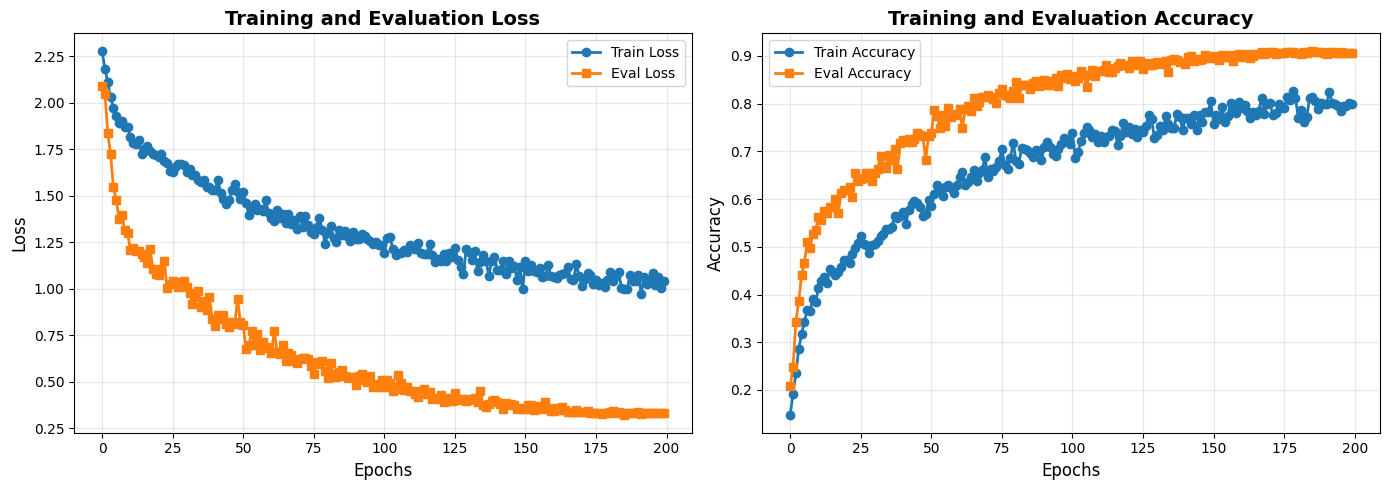

In [16]:
model = ViT(
image_size=32,
num_classes=10,
patch_size=4,
feature_dim=768,
mlp_dim=768*2,
depth=12,
heads=4,
dropout=0.3,
emb_dropout=0.3,
)

optimizer = AdamW(
    model.parameters(),
    lr=6e-4,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0.3
)

loss_fn = nn.CrossEntropyLoss()

num_epochs = 200
warmup_epochs = 30

# Linear warmup scheduler
warmup_scheduler = LinearLR(
    optimizer,
    start_factor=0.01,
    end_factor=1.0,
    total_iters=warmup_epochs
)

# Cosine annealing scheduler
cosine_scheduler = CosineAnnealingLR(
    optimizer,
    T_max=num_epochs - warmup_epochs,
    eta_min=1e-6
)

scheduler = SequentialLR(
    optimizer,
    schedulers=[warmup_scheduler, cosine_scheduler],
    milestones=[warmup_epochs]
)

logger = SimpleLogger()

# Instantiate the Trainer
save_name = f"checkpoint_{get_timestamp()}_SPT"
print(f'Saving to {save_name}')
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    scheduler=scheduler,
    logger=logger,
    ckpt_path=os.path.join(cwd,save_name),
    device="cuda" if torch.cuda.is_available() else "cpu"
)

best_acc = trainer.train(num_epochs=num_epochs)

print(f'Best Acc: {best_acc}')